# Fruits Classifier

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras import layers, optimizers, models
from keras.preprocessing.image import ImageDataGenerator

from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

Nel seguente notebook vengono proposti diverse metodologie di Machine Learning al fine di classificare immagini rappresentanti svariate tipologie di frutta. 
Vengono utilizzati i seguenti metodi:

* Rete Neurale Convoluzionale
* Riduzione dimensionale usando Principal Component Analysis:
    * Decision Tree
    * Random Forest
* Linear Discriminant Analyis
* Riduzione dimensionale usando LDA:
    * Random Forest

La rete neurale è stata addestrata utilizzando tutto il dataset senza applicare nessuna riduzione dimensionale, mentre per i metodi ruccessivi ho utilizzato prima un' analisi delle componenti principali e poi una linear discriminant analysis per andare a ridurre le dimensioni del dataset e renderlo più gestibile utilizzando solamente le features più importanti.

I risultati ottenuti verranno poi discussi nelle conclusioni finali.

### Riconoscimento della GPU
_Tensorflow_ e di conseguenza _Keras_ offrono la possibilità di addestrare i modelli usufruendo della GPU in modo da abbattere i tempi di esecuzione. 

Con queste poche righe di codice verifico per prima cosa che la scheda grafica venga correttamente riconosciuta dalle librerie.

In seguito viene settato su *True* l'opzione tf.config.experimental.set_memory_growth(). Questo permette in fase di inizializzazione di non allocare tutta la memoria sul _physical device_.
Sul mio pc dotato di scheda grafica _GeForce RTX 2070 SUPER_ il mancato settaggio di questa impostazione porta al sorgere di alcuni errori.

Se non viene utilizzata nessuna GPU questa cella va saltata.

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Dataset

Il dataset, denominato **Fruits 360**, è reperibile su Kaggle al seguente link: https://www.kaggle.com/moltean/fruits.

Consiste in una raccolta di foto rappresentanti frutta e verdura varia (di seguito vengono elencate tutte le 131 categorie). Ogni immagine può essere rappresentata come un tensore (100, 100, 3) dove le prime due dimensioni rappresentano la lunghezza dei lati dell'immagine (numero di pixel) e la terza dimensione indica i tre canali dei colori RGB. 

In [4]:
labels = os.listdir('fruits-360/Training')
labels.sort()
print('Il dataset contiene %i classi di frutta: ' %(len(labels)))
print(labels)

Il dataset contiene 131 classi di frutta: 
['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 

### Load and split the dataset into Training (80%) and Validation (20%) dataset

Le immagini vengono caricate utilizzando gli strumenti forniti dalla libreria *Keras*:

* tf.keras.preprocessing.image.ImageDataGenerator() nel quale specifico il riscalamento delle immagini (ogni pixel è diviso per 255) e la proporzione tra training set e validaiton set,
* il metodo flow_from_directory(), nel quale specifico il path nel quale sono contenute le immagini, crea delle batches di immagini.

Il riscalamento viene effettuato perchè i valori dei canali RGB sono nella gamma $[0,255]$ mentre per una buona convergenza della nostra rete è preferibile che i valori siano in un intervallo $[0,1]$.

Infine viene stampato il numero effettivo di foto e il numero di classi (già trovato anche in precedenza)

In [4]:
batch_size = 512

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = 0.2,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training',
    seed = 42,
)

validation = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'validation',
    seed = 42,
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


### Load the Test dataset

Lo stesso metodo viene applicato alle immagini del dataset di Test.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
)

Found 22688 images belonging to 131 classes.


### Some fruits exaple

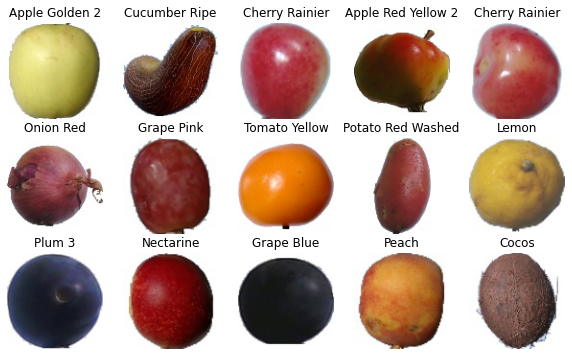

In [6]:
plot_x, plot_y = next(train)
train.reset()
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, plot_x.shape[0])
    ax.imshow(plot_x[index])
    ax.set_title(labels[np.argmax(plot_y[index])])
    ax.axis('off')

# Convolutional Neural Network

Per classificare i frutti ho deciso di utilizzare come primo metodo una rete neurale convoluzionale (CNN). Questa tipologia di rete neurale *feed forward* è molto indicata per lo studio di immagini poichè in virtù della sua struttura riesce a riconoscere ed a utilizzare pattern locali nei dati. Inoltre risulta essere molto efficace su dati rappresentati da array multidimensionali nei quali uno o più canali (dimensioni) rappresentano diverse features del campione (e.g. i canali rgb di un'immagine a colori). Queste caratteristiche non sono tenute in conto in una rete neurale fully connected classica che tratta ogni dimensione allo stesso modo.

Tipicamente una CNN è composta da svariati layers convoluzionali, che riducono le dimensioni dell'immagine ed estraggono informazione usando differenti filtri, seguiti da layers finali *fully connected* che riducono l'output al numero desiderato di classi. 

Lo strato convoluzionale va ad applicare ai dati una convoluzione discreta utilizzando una finestra di ampiezza (m,n); la convoluzione viene inoltre ripetuta utilizzando un certo numero di filtri, ognuno caratterizzato dai suoi parametri addestrabili $\boldsymbol{w}$. 

$$
S(i,j) = (x * w)(i,j) = \sum_{m,n}x(i-m, j-n) w(m,n)
$$

Il mio modello è caratterizzato dalla presenza di tre layer convoluzionali, ogni layer è seguito da un layer di pooling e da uno di dropout:

* Conv2D: applica la convoluzione vera e propria (vista pocanzi), caratterizzata dal set di pesi addestrabili $\boldsymbol{w}$. Il numero di filtri è 16 per tutti e tre i layer, mentre la finestra (il kernel) della convoluzione ha dimensione $(10 \times 10)$.
* AveragePooling2D: riduce il numero dei dati (downsampling) andando a prendere il valore medio sulla finestra dei dati definita da *pool_size*.
* Dropout: setta randomicamente gli input a 0 con una frequenza data dal parametro *rate* (uguale a 0.3 nel mio caso); inoltre gli input non settati a 0 vengono riscalati di un fattore $1/(1-rate)$. Questi layers sono utilizzati per aiutare a prevenire l'overfitting.
[ Vedi https://www.researchgate.net/publication/286794765_Dropout_A_Simple_Way_to_Prevent_Neural_Networks_from_Overfitting ]

La parte convoluzionale è seguita da un layer Flatten che "appiattisce" l'inpout in un vettore unidimensionale e da un Dense layer, ovvero un classico layer fully connected che riduce la dimensione del vettore a 131, coincidente con il numero di classi.

Per quanto riguarda le funzioni di attivazione, gli strati convoluzionali utilizzano la funzione *swish* (Sigmoid Linear Unit):

$$
f(x) = x * \text{sigm(x)} = \frac{x}{1-e^{-x}},
$$

che sembrerebbe superare le prestazioni della classica ReLU: notiamo infatti che è di classe $C^\infty$ e che non sopprime completamente gli input negativi. 
[ Vedi https://arxiv.org/pdf/1710.05941.pdf ]

Il layer finale invece presenta come activation function la funzione *softmax*:

$$
\text{softmax}(x_i) = \frac{e^{x_{i}}}{\sum_{k = 1}^{131}e^{x_{k}}},
$$

si ottiene in questo modo un vettore finale i cui elementi sono compresi in $(0,1)$ e la loro somma da 1. Ovvero l'output della rete rappresenta un vettore il cui elemento k-esimo rappresenta la probabilità che l'immagine ha di appartenere alla classe k-esima. 

In [7]:
model = Sequential()
model.add(layers.Input(shape = (100,100,3)))

model.add(layers.Conv2D(16, 10, activation = 'swish', padding = 'same', name = "Conv2D_1"))
model.add(layers.AveragePooling2D(2, name = "Pooling_1"))
model.add(layers.Dropout(0.3, name = "Dropout_1"))

model.add(layers.Conv2D(16, 10, activation = 'swish', padding = 'same', name = "Conv2D_2"))
model.add(layers.AveragePooling2D(2, name = "Pooling_2"))
model.add(layers.Dropout(0.3, name = "Dropout_2"))

model.add(layers.Conv2D(16, 10, activation = 'swish', padding = 'same', name = "Conv2D_3"))
model.add(layers.AveragePooling2D(2, name = "Pooling_3"))
model.add(layers.Dropout(0.3, name = "Dropout_3"))

model.add(layers.Flatten())
model.add(layers.Dense(131, activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01)))

A questo punto si sceglie l'*optimizer* e la *loss function*.

Come optimizer ho scelto di utilizzare *Adam*: è un metodo di discesa stocastica del gradiente che tiene conto del termine di momento sia al primo che al secondo ordine. Si definiscono i momenti come la media mobile con i precedenti:

$$
\boldsymbol{m}_t = \beta_1 \boldsymbol{m}_{t-1} + (1-b_1)\boldsymbol{g}_t
$$
$$
\boldsymbol{s}_t = \beta_2 \boldsymbol{s}_{t-1} + (1-b_2)\boldsymbol{g}_t^2
$$
Si applica un'ulteriore normalizzazione ed infine si calcola lo step successivo dei parametri $\theta$:
$$
\boldsymbol{m}_t = \frac{\boldsymbol{m}_t}{1-\beta_1^t}, \;\; \boldsymbol{s}_t = \frac{\boldsymbol{s}_t}{1-\beta_2^t}
$$

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_{t} - \eta_t \frac{\boldsymbol{m}_t}{\sqrt{\boldsymbol{s}_t}+\epsilon}
$$

Per quanto riguarda la *loss function* utilizzo l'entropia incrociata (*Categorical Cross Entropy*)

$$
\text{Loss} = - \sum_{k}^{\text{# of classes}} t_k \log{y_k},
$$

dove $y_k$ è il k-esimo valore del vettore di output del modello e $t_k$ è il corrispondente target value. Un'osservazione importante è che la cross entropy *Categorical* è usata quando i vettori di target $\boldsymbol{t}$ sono vettori *one-hot*, ovvero i cui elenti sono tutti 0 tranne il k-esimo elemento, corrispondente alla k-esima classe a cui appartiene il campione, che è settato a 1; questo fa inoltre si che nella somma precedente sopravviva solo il termine corrispondente alla classe a cui effettivamente appartiene il campione.

In [8]:
model.compile(optimizer = optimizers.Adam(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 100, 100, 16)      4816      
_________________________________________________________________
Pooling_1 (AveragePooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 50, 50, 16)        25616     
_________________________________________________________________
Pooling_2 (AveragePooling2D) (None, 25, 25, 16)        0         
_________________________________________________________________
Dropout_2 (Dropout)          (None, 25, 25, 16)        0         
_________________________________________________________________
Conv2D_3 (Conv2D)            (None, 25, 25, 16)        2

Al posto di decidere un numero preciso di epoche di addestramento, ho scelto di utilizzare la funzione *tf.keras.callbacks.EarlyStopping()* che permette di fermare il training quando la quantità monitorata (nel mio caso la validation loss) smette di diminuire.

In [9]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [10]:
history = model.fit(
    train,
    epochs = 500,
    validation_data = validation,
    steps_per_epoch = len(train),
    validation_steps = len(validation),
    callbacks = my_callbacks,
)

Epoch 1/500
106/106 [==============================] - 29s 277ms/step - loss: 6.2226 - accuracy: 0.0785 - val_loss: 4.2867 - val_accuracy: 0.3925
Epoch 2/500
106/106 [==============================] - 23s 219ms/step - loss: 3.6099 - accuracy: 0.4483 - val_loss: 2.5776 - val_accuracy: 0.7445
Epoch 3/500
106/106 [==============================] - 23s 219ms/step - loss: 2.5006 - accuracy: 0.6742 - val_loss: 1.9757 - val_accuracy: 0.8376
Epoch 4/500
106/106 [==============================] - 23s 221ms/step - loss: 1.9115 - accuracy: 0.7939 - val_loss: 1.6303 - val_accuracy: 0.8794
Epoch 5/500
106/106 [==============================] - 23s 221ms/step - loss: 1.5487 - accuracy: 0.8593 - val_loss: 1.4178 - val_accuracy: 0.8970
Epoch 6/500
106/106 [==============================] - 23s 219ms/step - loss: 1.3028 - accuracy: 0.8958 - val_loss: 1.2621 - val_accuracy: 0.9035
Epoch 7/500
106/106 [==============================] - 23s 219ms/step - loss: 1.1170 - accuracy: 0.9192 - val_loss: 1.1171 -

### Visualize the loss function and the accuracy through the training

In [11]:
print('Informations stored in hystory:')
for key in history.history.keys():
    print(key)

Informations stored in hystory:
loss
accuracy
val_loss
val_accuracy


[]

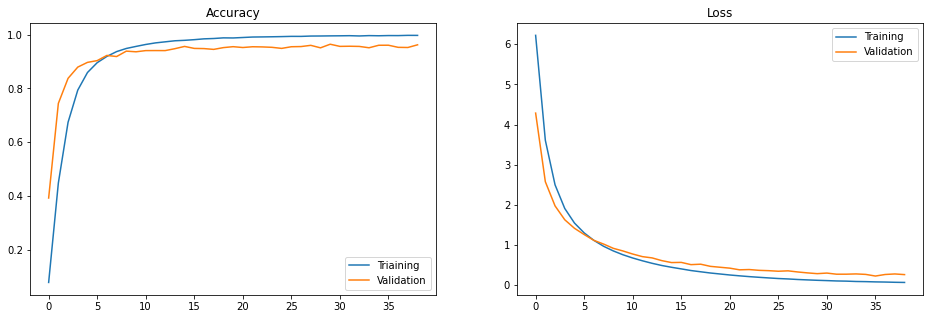

In [12]:
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Triaining')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

plt.plot()

### Evaluate the model on the Test Dataset

Vado ora a valutare l'errore di test, calcolando l'accuratezza del modello su un set di dati che non è stato usato durante l'addestramento.

In [13]:
score = model.evaluate(test, steps = len(test))

45/45 [==============================] - 10s 224ms/step - loss: 0.2828 - accuracy: 0.9501


In [14]:
print('Test acurracy del modello = %s%s' %(round(100*score[1],2), "%"))

Test acurracy del modello = 95.01%


Il modello viene salvato in modo tale da non dover ogni volta riaddestrarlo, basta infatti usare *tf.keras.models.load_model('cnn.h5')* per caricarlo ed utilizzarlo.

In [15]:
model = tf.keras.models.load_model('cnn.h5')

### Visualize the output of each layer

In questa parte di codice ho deciso di andare ad indagare nel dettaglio gli output dei vari layer della mia rete, nello specifico ho rappresentato i tre "blocchi" formati dal layer convoluzionale da quello di pooling e dal dropout.

Per prima cosa andiamo ad estrarre un' immagine a caso dal nostro dataset.

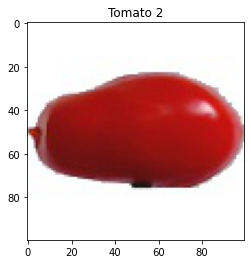

In [16]:
fig, lab = next(test)
indx = np.random.randint(0,batch_size)
fig, lab = fig[indx], lab[indx]
plt.imshow(fig)
plt.title(labels[np.argmax(lab)])
plt.show()
fig = np.expand_dims(fig, axis = 0)

Applichiamo il modello all'immagine e salviamo l'output dei vari layers.

In [17]:
layers_outputs = [layer.output for layer in model.layers[:9]]
output_model = models.Model(inputs = model.input, outputs = layers_outputs)
outputs = output_model.predict(fig)

In [18]:
images_per_rows = 8
layer_names = []
for layer in model.layers[:9]:
    layer_names.append(layer.name)
print(layer_names)

['Conv2D_1', 'Pooling_1', 'Dropout_1', 'Conv2D_2', 'Pooling_2', 'Dropout_2', 'Conv2D_3', 'Pooling_3', 'Dropout_3']


L'output di ogni layer corrisponde ad un numero $n$ di immagini corrispondenti al risultato prodotto dai filtri utilizzati. Da notare che in virtù dell'opzione *padding = same* le dimensioni dell'immagine dopo la convoluzione rimangono le stesse. Dopo il layer di pooling invece le dimnesioni vengono dimezzate. Quello che si nota è che dopo ogni layer convoluzionale la rappresentazione dell'immagine diviene sempre meno realistica, ogni filtro va infatti ad estrarre via via rappresentazioni sempre più essenziali.

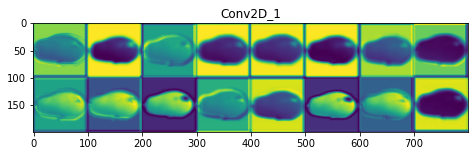

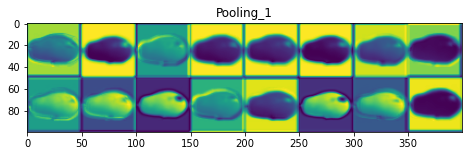

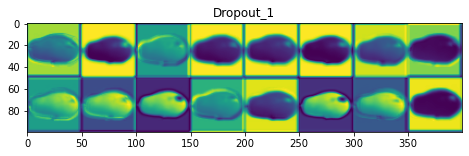

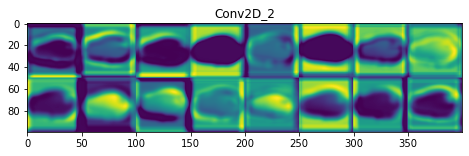

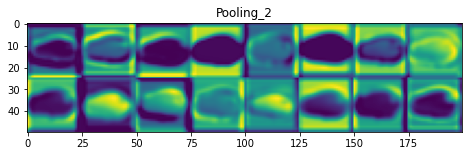

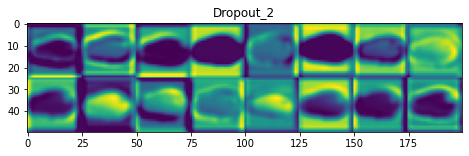

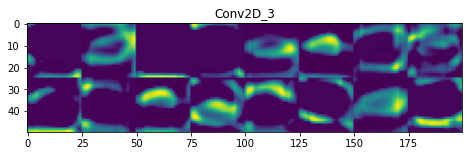

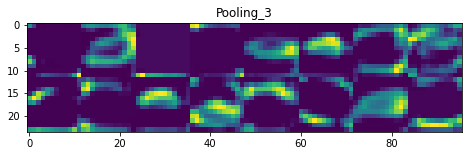

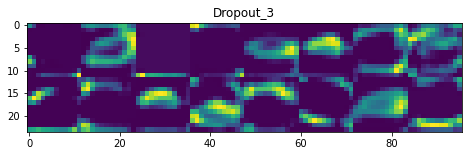

In [19]:
for layer_name, layer_output in zip(layer_names,outputs):
    
    n_filters = layer_output.shape[-1] #numero di filtri applicati nel livello
    size = layer_output.shape[1] #lato dell' "immagine"
    n_rows = n_filters // images_per_rows #numero di righe che avrà la griglia con le immagini
    
    img_grid = np.zeros((size * n_rows, images_per_rows * size))
    
    for row in range(n_rows):
        for i in range(images_per_rows):
            image = layer_output[0, :, :, row * images_per_rows + i]
            
            #rescaling dei dati in un intervallo [0,255], facoltativo per avere una migliore visione
            image = (image - np.amax(image))/(np.amax(image)-np.amin(image))
            image *= 255

            img_grid[row * size : (row + 1) * size, i * size : (i + 1) * size] = image
    
    scale = 1. / size
    plt.figure(figsize = (scale * img_grid.shape[1], scale * img_grid.shape[0]))
    plt.title(layer_name)
    plt.imshow(img_grid)
                    

# Dataset reduction

A causa della mole elevata di immagini e delle restrizioni date dall' hardware utilizzato, ho deciso di ridurre il numero di dati; questo anche perchè a questo punto ho la necessità di abbandonare gli strumenti forniti da Keras e passare a Numpy, salvando le immagini in un tensore.

Viene ridotto il numero effettivo di immagini utilizzate ed anche la risoluzione stessa delle immagini (numero di pixel per immagine) passando da (100,100) a (50,50). 

In [5]:
number_of_images = 40000
number_of_test = 3000
risoluzione = 50

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(risoluzione, risoluzione),
    color_mode='rgb',
    batch_size=number_of_images,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(risoluzione, risoluzione),
    color_mode='rgb',
    batch_size=number_of_test,
    class_mode='categorical',
    shuffle = True,
    seed = 42,
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
x , y = next(train)
x_test, y_test = next(test)
print(x.shape, y.shape)
print(x_test.shape, y_test.shape)

(40000, 50, 50, 3) (40000, 131)
(3000, 50, 50, 3) (3000, 131)


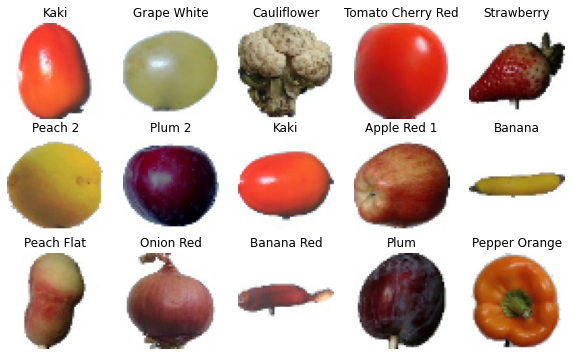

In [7]:
_ , axs = plt.subplots(3,5, figsize = (10,6))
for i, ax in enumerate(axs.ravel()):
    index = np.random.randint(0, x_test.shape[0])
    ax.imshow(x_test[index])
    ax.set_title(labels[np.argmax(y_test[index])])
    ax.axis('off')

Avendo ridotto il dataset qui di seguito verifico qualitativamente che, nonostante la riduzione, i campioni siano comunque rimasti distribuiti uniformemente tra le varie classi. 

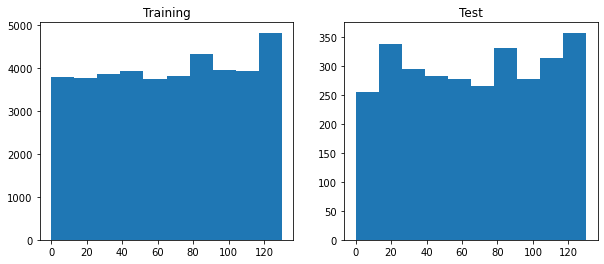

In [8]:
_, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].hist(np.argmax(y, axis = 1))
axs[0].set_title('Training')
axs[1].hist(np.argmax(y_test, axis = 1))
axs[1].set_title('Test')
plt.show()

# Dimension reduction using PCA

L'analisi delle componenti principali (PCA) è una tecnica di _riduzione dimensionale_ che consiste nel proiettare i dati lungo le direzione di maggiore varianza.  La riduzione dimensionale avvienne andando a considerare solo le principali (varianza maggiore) tra le nuove variabili.

La matrice di design, contenente tutti i campionamenti e le features (pixels in questo caso), può essere rappresentata nel seguente modo in termini delle sue colonne:

$$
\boldsymbol{X}=\begin{bmatrix} \boldsymbol{x}_0 & \boldsymbol{x}_1 & \boldsymbol{x}_2 & \dots & \dots & \boldsymbol{x}_{p-1}\end{bmatrix},
$$

dove $\boldsymbol{x}_i^T$ rappresenta il vettore con l' i-esimo pixel di ogni immagine

$$
\boldsymbol{x}_i^T = \begin{bmatrix}x_{0,i} & x_{1,i} & x_{2,i}& \dots & \dots x_{n-1,i}\end{bmatrix}.
$$

Possiamo inoltre definire la matrice di covarianza $\boldsymbol{C}[\boldsymbol{x}]$:

$$
\boldsymbol{C}[\boldsymbol{x}] = \begin{bmatrix}
\mathrm{var}[\boldsymbol{x}_0] & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_0] & \mathrm{var}[\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_1] & \mathrm{var}[\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_{p-1}]\\
\dots & \dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots & \dots \\
\mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_1] & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_{2}]  & \dots & \dots  & \mathrm{var}[\boldsymbol{x}_{p-1}]\\
\end{bmatrix},
$$

Per prima cosa prendiamo il tensore contenente le nostre immagini e lo trasformiamo in una matrice $n \times p$, nello specifico (40000, 7500), che sarà la matrice di design. A questo punto andiamo a normalizzare la matrice, ovvero sottraiamo la media in modo che la "nuova" matrice normalizzata abbia media nulla. Questo viene effettuato usando sklearn.preprocessing.StandardScaler().

In [9]:
scaler = StandardScaler(with_std=False)
x = scaler.fit_transform([i.flatten() for i in x])
x.shape

(40000, 7500)

La matrice di covarianza è simmetrica e definita positiva, il che implica autovalori reali e positivi. La matrice di covarianza può quindi essere diagonalizzata:

$$
\boldsymbol{C}[\boldsymbol{x}] = \boldsymbol{V}^{T}\boldsymbol{\Sigma}^{2}\boldsymbol{V},
$$
con
$$
\boldsymbol{V}^{T}\boldsymbol{V} = \boldsymbol{I}, \; \boldsymbol{\Sigma}^{2} = diag(\lambda_i)
$$

Il teorema della PCA asserisce che per una distribuzione multivariata di $P$ variabili con media nulla, preso $p \in \mathbb{N}$ tale che $p < P$, il sottospazio $S \in \mathbb{R}^{p}$ che massimizza la varianza della distribuzione è generato dai primi $p$ autovettori $(\boldsymbol{v}_1, \boldsymbol{v}_2, ... , \boldsymbol{v}_p)$ corrispondenti ai primi autovalori più grandi della matrice di covarianza.

Qui di seguito vado ad utilizzare sklearn.decomposition.PCA() imponendo di "salvare" un numero necessario di variabili per mantenere il 95% della varianza. Si noti che scikit learn non diagonalizza la matrice in senso stretto ma va ad effettuare una decomposizione ai valori singolari (che è utilizzabile su tutti i tipi di matrice senza restrizioni).
In particolare noi sappiamo che la matrice di covarianza può essere scritta in termini della matrice di design:
$$
\boldsymbol{C}[\boldsymbol{x}] = \frac{1}{N-1}\boldsymbol{X}^{T}\boldsymbol{X},
$$
scomponendo la matrice di design e sostituendola nella formula della matrice di correlazione otteniamo il risultato precedente:
$$
\boldsymbol{X}= \boldsymbol{U}\boldsymbol{X}\boldsymbol{V}^{T},
$$
$$
\boldsymbol{C}[\boldsymbol{x}] = \boldsymbol{V}\boldsymbol{\Sigma}\boldsymbol{U}^{T}\boldsymbol{U}\boldsymbol{\Sigma}\boldsymbol{V}^{T} = \boldsymbol{V}^{T}\boldsymbol{\Sigma}^{2}\boldsymbol{V}.
$$

In [25]:
#pca = PCA(n_components = 0.95)
#pca = pca.fit(x)
#dump(pca, 'pca.joblib')
pca = load('pca.joblib')

['pca.joblib']

Una volta trovati i valori principali ed i corrispondenti autovettori $\boldsymbol{\tilde{V}} = (\boldsymbol{v}_1, \boldsymbol{v}_2, ... , \boldsymbol{v}_p)$ si va a proiettare la matrice di design nel sottospazio generato da questi autovettori, ottenendo di fatto una matrice di design con uguale numero di campionamenti ma ridotto numero di variabili:
$$
\boldsymbol{\tilde{X}} = \boldsymbol{X}\boldsymbol{\tilde{V}} \in \mathbb{R}^{N \times p}.
$$

In [11]:
x_reduced = pca.transform(x)
print(x_reduced.shape)

(40000, 226)


Applichiamo lo stesso procedimento anche ai dati di test.

In [12]:
scaler = StandardScaler(with_std=False)
x_test = scaler.fit_transform([i.flatten() for i in x_test])
x_test_reduced = pca.transform(x_test)
x_test_reduced.shape

(3000, 226)

### Visualize the principal component of the PCA

A puro scopo illustrativo sono andato ora a visualizzare *alcune* delle componenti principali della PCA.

Come si può notare è data molta importanza alla zona centrale sferica (dove effettivamente risiede l'immagine del frutto), piuttosto che gli angoli della foto, che sono tipicamente vuoti.

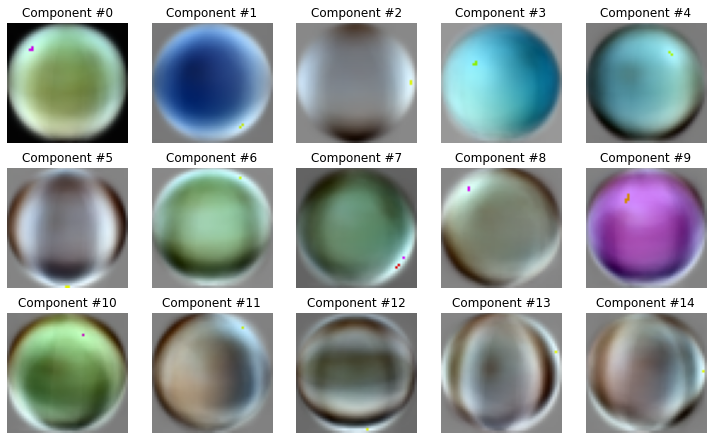

In [14]:
fig, axes = plt.subplots(3,5, figsize = (10,6),constrained_layout=True)
for i, ax in enumerate(axes.ravel()):
    img = pca.components_[i].reshape(risoluzione,risoluzione,3)
    img = (img - np.amax(img))/(np.amax(img)-np.amin(img))
    img *= 255
    ax.imshow(img.astype(np.uint8))
    ax.set_title('Component #%i' %(i))
    ax.axis('off')

# Decision Tree

Dopo aver ridotto le dimensioni proiettando i dati lungo gli assi di maggiore varianza qui di seguito si usa prima un albero decisionale e poi una random forest per classificare i dati.

Gli alberi decisionali sono un algoritmo di machine learning basato su un diagramma di flusso dove, ad ogni nodo viene controllata una certa condizione sulle variabili di input ed in virtù di questo discrimine i dati vangono splittati in due sottonodi. Il processo comincia sempre da un nodo radice (root) e va a scendere controllando via via diverse condizioni. Ad esempio una condizone potrebbe essere una variabile $\lessgtr$ di un certo valore soglia. I nodi intermedi sono detti nodi decisionali, mentre quelli finali (ovvero quelli oltre i quali non avviene più nessuna divisione) sono detti *foglie*.

Gli alberi utilizzano il cosiddetto algoritmo CART (Classification And Regression Tree). Il processo consiste nel dividere inizialmento lo spazio dei parametri in due regioni, cercando la condizione e la variabile a cui applicare la condizione migliori; a questo punto una o entrambe le regioni vengono suddivise a loro volta in due sottoregioni scegliendo altre variabili ed altre condizioni; il processo viene quindi iterato fino ad ottenere una partizione dello spazio dei parametri in $M$ sottoregioni.

Immaginiamo di avere un dataset $D = \{(y_i,\boldsymbol{x}_i):i=1,2,...,n\}$, il modello creato dall'albero decisionale per approssimare le $y_i$ sarà dato dalla seguente funzione:

$$
\hat{y} = \sum_{m = 1}^{M} c_m I(\boldsymbol{x} \in R_m),
$$

dove $R_m$ è la m-esima regione della partizione e $I(\boldsymbol{x})$ è uguale a 1 se $\boldsymbol{x}$ appartiene alla regione o 0 altrimenti. Si può inoltre dimostrare che il coefficiente $c_m$ ottimale è la media delle $y$ appartementi a quella regione.

Per scegliere le regioni ottimali si procede considerando una variabile $x_j$ con $j = 1, 2, ..., p$ ed un valore di soglia $s$ che divide lo spazio in due sottospazi (n.b. ci troviamo in un n-esimo nodo, quindi potrebbero già esserci state delle divisioni).

$$
R_1 = \{ x | x_j < s \} \;\;\; R_2 = \{ x | x_j > s \}.
$$

Per scegliere la migliore configurazione si va a minimizzare la seguente funzione di costo, rispetto a $j$ e $s$:

$$
J(j,s) = \frac{N^{n}_1}{N^{n}}Q^{n}_1 + \frac{N^{n}_2}{N^{n}}Q^{n}_2,
$$

dove $Q_1, Q_2$ è l'errore di classificazione (impurità) e $N_1, N_2$ il numero di campioni in ogni sottoinsieme.  Usando scikit-learn di defaul l'albero decisionale userà l'*indice Gini* come impurità;

$$
G_m = \sum_{k=k'}\hat{p}_{mk}\hat{p}_{mk'} = \sum_{k=1}^{K} \hat{p}_{mk} (1 - \hat{p}_{mk}) = 1 - \sum_{k=1}^{K} \hat{p}_{mk}^{2},
$$

con $\hat{p} = \frac{1}{N_m} \sum_{R_m} I(y_i = k)$ la probabilità di trovare un punto appartenente alla classe k nella regione (può anche essere visto come la proporzione di punti appartenenti ad una data classe nella regione). L'indice corrisponde alla misura della promiscuità delle varie classi all'interno della regione m-esima. L'indice va a 0 quando all'interno della regione si trovano elementi appartenenti ad una sola classe.

In [15]:
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(x_reduced, y)

In [16]:
print('Training accuracy: %f' %(accuracy_score(y, classifier.predict(x_reduced))))
print('Test accuracy: %f' %(accuracy_score(y_test, classifier.predict(x_test_reduced))))

Training accuracy: 1.000000
Test accuracy: 0.646333


# Random Forest

Una Random Forest è un algoritmo di *Ensamble Learning* che funziona andando a creare una moltitudine di alberi decisionali. L'output finale del modello sarà la media degli output di tutti gli alberi decisionali che compongono la foresta. Il funzionamento è ben descritto dalla seguente immagine. Ogni albero decisionale singolo è creato tenendo conto di un subset di dati e di un subset di variabili.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png" alt="drawing" width="400"/>

Teoricamente le Random Forest sono algoritmi molto robusti ed efficienti, in virtù del fatto che il risultato finale è mediato su un grande numero di modelli; in realtà, come anche riportato in [*Hastie T, Tibshirani R, Friedman J. The Elements of Statistical Learning. Springer, 2009*] quando il numero di variabili è molto grande ma solo poche di esse sono rilevanti, la qualità dei risultati tende a peggiorare, questo perchè ad ogni split la probabilità che vengano selezionate le variabili più rilevanti è relativamente bassa.

Dopo svariati tentativi ho deciso di considerare solamente le prime 10 variabili di ogni sample, corrispondenti alle prime 10 componenti principali. Inoltre ho settato il parametro *max_features* a 1.0 in modo tale che tutti gli alberi utilizzino tutte le variabili e non solo una frazione di esse.

In [17]:
print('Varianza conservata dalla prime 10 componenti principali: %f %s' %(100 * pca.explained_variance_ratio_[:10].sum(), '%'))

Varianza conservata dalla prime 10 componenti principali: 71.901245 %


In [18]:
rnd_forest = RandomForestClassifier(
    n_jobs = -1,
    #criterion = 'entropy',
    #max_depth = 30,
    max_features = 1.0,
    #ccp_alpha = 1e-4,
)
rnd_forest = rnd_forest.fit(x_reduced[:,:10], y)

In [19]:
print('Training accuracy: %f' %(accuracy_score(y, rnd_forest.predict(x_reduced[:,:10]))))
print('Test accuracy: %f' %(accuracy_score(y_test, rnd_forest.predict(x_test_reduced[:,:10]))))

Training accuracy: 0.999975
Test accuracy: 0.666000


# Linear Discriminant Analysis

La Linear Discriminant Analysis (LDA) è un metodo di classificazione lineare che va a calcolare una funzione discriminante $\delta_k(x)$ per ogni classe k-esima ed in seguito assegna il campione $x$ alla classe $k$ con il maggior valore della funzione discriminante.

Dato un set di classi $G = 1,2,...,K$, per determinare la funzione discriminante si utilizza il teorema di Bayes:

$$
P(G=k|X=x) = \frac{P(X=x|G=k) P(G=k)}{\sum_{l=1}^{K} P(X=x|G=l)P(G=l) } \equiv \frac{f_k(x) \pi_k}{\sum_{l=1}^{K}f_l(x)\pi_l},
$$

dove $f_k(x)$ è la distribuzione di $X$ all'interno della classe $G=k$ e $\pi_k$ la propabilità a priori della k-esima classe. Assumiamo che $f_k(x)$ sia una distribuzione gaussiana multivariata con matrice di covarianza $\boldsymbol\Sigma$. La LDA si ottiene imponendo anche un' ulteriore ipotesi a priori, ovvero che tutte le classi condividano la stessa matrice di covarianza.

Per classificare i campioni possiamo ora andare a considerare il logaritmo del rapporto tra le probabilità di due classi differenti, in modo da poter trascurare la normalizzazione:

$$
\log\frac{P(G=k|X=x)}{P(G=l|X=x)} = \log\frac{\pi_k}{\pi_l} + \log\frac{f_k(x)}{f_l(x)} = \log\frac{\pi_k}{\pi_l} + \log\frac{exp[(x-\mu_k)^{T}\boldsymbol\Sigma^{-1}(x-\mu_k)]}{exp[(x-\mu_l)^{T}\boldsymbol\Sigma^{-1}(x-\mu_l)]}
$$

$$
= \log\frac{\pi_k}{\pi_l} - \frac{1}{2}(\mu_k + \mu_l)\boldsymbol\Sigma^{-1}(\mu_k - \mu_l) + x^T \boldsymbol\Sigma^{-1} (\mu_k - \mu_l)
$$

Troviamo una relazione lineare nelle $x$, che può essere equivalentemente rappresentata dalla seguente *funzione discriminante*:

$$
\delta_k(x) = x^T \boldsymbol\Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \boldsymbol\Sigma^{-1} \mu_k + \log\pi_k,
$$

con

$$
G(x) = \underset{k}{\text{argmax}} [\delta_k(x)]
$$

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=10)
lda.fit(x_reduced, np.argmax(y, axis=1))

LinearDiscriminantAnalysis(n_components=10)

In [21]:
print('Training accuracy: %f' %(accuracy_score(np.argmax(y, axis = 1), lda.predict(x_reduced))))
print('Test accuracy: %f' %(accuracy_score(np.argmax(y_test, axis = 1), lda.predict(x_test_reduced))))

Training accuracy: 0.926825
Test accuracy: 0.773000


### Use LDA to reduce dimension

La Linear Discriminant Analysis può anche essere usata per ridurre il numero di dimensioni del dataset e massimizzare la distanza nello spazio dei parametri tra le varie classi, per facilitare la classificazione. 

L'idea di base è quella di proiettare i dati in un sottospazio che massimizzi la marianza tra le varie classi (distanza tra i centroidi di ogni classe) minimizzando la varianza della singola classe (in modo tale da diminuire l'overlap dei dati tra le varie classi). Nella seguente immagine (tratta da *Hastie T, Tibshirani R, Friedman J. The Elements of Statistical Learning. Springer, 2009*) si può apprezzare un esempio di tale metodo.

<img src="https://miro.medium.com/max/3148/1*KZ4ZrKSAG8XIm7yndddp6A.png" style="height: 200px; width:500px;"/>

Matematicamente il processo è riassumibile nei seguenti steps:

* Si trova la matrice $\boldsymbol{M} \in \mathbb{R}^{K \times p}$ composta dai centroidi e la matrice di covarianza $\boldsymbol{W}$ relativa ai dati nelle singole classi.
* Si calcola la matrice $\boldsymbol{M^*} = \boldsymbol{M}\boldsymbol{W}^{-\frac {1}{2}}$ in modo tale che i dati risultino distribuiti "sfericamente" attorno al centroide con varianza uguale a 1.
* Si calcola la matrice $\boldsymbol{B^*}$ che è la matrice di covarianza di $\boldsymbol{M^*}$, ovvero la varianza dei centroidi.
* Infine in modo analogo alla PCA si diagnalizza la matrice precedente come $\boldsymbol{B^*} = \boldsymbol{V^*} \boldsymbol{D} {\boldsymbol{V^*}}^T$, e si proiettano i dati sullo spazio generato dalle prime $l$ colonne di $\boldsymbol{V^*}$


In [22]:
x_lda = lda.transform(x_reduced)
x_test_lda = lda.transform(x_test_reduced)

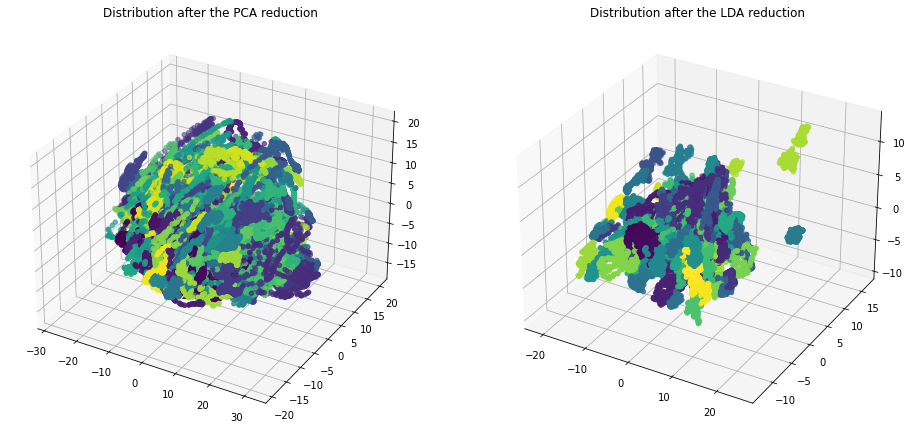

In [23]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter3D(x_reduced[:,0], x_reduced[:,1], x_reduced[:,2], c = np.argmax(y,axis=1))
ax1.set_title('Distribution after the PCA reduction')
ax2.scatter3D(x_lda[:,0], x_lda[:,1], x_lda[:,2], c = np.argmax(y,axis=1))
ax2.set_title('Distribution after the LDA reduction')
plt.show()


In [24]:
rnd_forest = RandomForestClassifier(
    n_jobs = -1,
    criterion = 'gini',
    max_depth = 50,
    max_features = 0.9,
    ccp_alpha = 1e-6,
)
rnd_forest = rnd_forest.fit(x_lda, y)
print('Training accuracy: %f' %(accuracy_score(y, rnd_forest.predict(x_lda))))
print('Test accuracy: %f' %(accuracy_score(y_test, rnd_forest.predict(x_test_lda))))

Training accuracy: 0.996925
Test accuracy: 0.781333


# Conclusions

I risultati ottenuti sono riportati nella seguente tabella:

|                       | Train Accuracy | Test Accuracy |
|:---------------------:|:--------------:|:-------------:|
|          CNN          |     99.7 %     |     95.1 %    |
| PCA + Decisional Tree |      100 %     |     64.6 %    |
|  PCA + Random Forest  |     99.9 %     |     66.6 %    |
|          LDA          |     92.6 %     |     77.3 %    |
|  LDA + Random Forest  |     99.6 %     |     78.1 %    |

Come si può vedere, il modello che meglio è riuscito a classificare i dati è la rete neurale convoluzionale. Questo risultato può essere imputato a diversi fattori, ad esempio la struttura stessa della rete convoluzionale, che è particolarmente indicata per lo studio di immagini, in quanto riesce ad estrarre molto bene pattern locali e tiene conto dei diversi canali. Certamente va anche detto che i metodi successivi sono stati applicati su un dataset con risoluzione minore e che le tecniche di riduzione dimensionale quali PCA e LDA vanno inevitabilmente ad eliminare un certo quantitativo di informazione. Inoltre si può notare che le prestazioni della Random Forest aumentano dopo aver applicato la LDA, questo perchè (come si può osservare nei grafici della sezione precedente), si vanno a proiettare i dati in uno spazio in cui gli elementi appartenenti ad una stessa classe sono meglio raggruppati e ogni classe è separata dalle altre in modo più netto.

Il progetto può considerarsi concluso in quanto il compito iniziale di classificare le immagini dei frutti è pienamente riuscito; un'ulteriore indagine potrebbe essere effettuata andando ad utilizzare algoritmi di Grid Search per trovare una combinazione di parametri più efficiente e andando a provare altri metodi di classificazione qui non trattati (e.g. Support Vector Machine, Quadratic Discriminant Analisys, metodi di ensamble learning...)